## 배달 시간 예측

시간 속성
- market_id: 지역(배달이 이루어지는 도시) 아이디
- created_at: 주문이 생성된 시간의 Timestamp(UTC)
- actual_delivery_time: 주문자가 배달을 받은 시간의 Timestamp(UTC)  
  
식당 속성
- store_id: 식당 아이디
- store_primary_category: 식당의 카테고리(italian, asian 등)
- order_protocol: 주문을 받을 수 있는 방식을 나타내는 아이디  

주문 속성
- total_items: 주문에 포함된 아이템(음식) 개수
- subtotal: 가격(센트 단위)
- num_distinct_items: 주문에 포함된 비중복 아이템 개수
- min_item_price: 주문에 포함된 아이템 중 가장 싼 아이템의 가격
- max_item_price: 주문에 포함된 아이템 중 가장 비싼 아이템의 가격  

지역 상황 속성
- total_onshift: 주문이 생성되었을 때 가게로부터 10마일 이내에 있는 배달원들의 수
- total_busy: 위 배달원들 중 주문에 관여하고 있는 사람들의 수
- total_outstanding_orders: 주문한 가게로부터 10마일 이내에 있는 다른 주문들의 수  

다른 모델들의 예측값
- estimated_order_place_duration: 식당이 주문을 받을 때까지 걸릴 것으로 예상되는 시간(초단위)
- estimated_store_to_consumer_driving_duration: 식당에서 출발해 주문자에 도착할 때까지 걸릴 것으로 예측되는 시간(초단위)

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 확인

In [116]:
df = pd.read_csv('./dataset/delivery_raw.csv',sep='\t')
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [117]:
df.shape

(197428, 16)

In [118]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,196433.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000
mean,2.978706,3530.510272,2.882352,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935
std,1.524867,2053.496711,1.503771,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000
50%,3.000000,3592.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


In [119]:
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift                                   16262
total_busy                                      16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [120]:
df.corr()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
market_id,1.000000,0.017301,-0.021895,-0.006855,-0.016237,0.002557,-0.000150,-0.004921,0.069752,0.060488,0.063754,-0.053241,0.006597
store_id,0.017301,1.000000,0.019554,-0.008796,-0.013370,-0.012727,-0.009128,-0.018661,-0.023141,-0.023245,-0.020348,0.017469,0.001953
order_protocol,-0.021895,0.019554,1.000000,0.008790,-0.053623,-0.023342,-0.045421,-0.090960,0.145022,0.149584,0.134895,-0.678222,-0.008326
total_items,-0.006855,-0.008796,0.008790,1.000000,0.558067,0.763912,-0.393149,-0.058233,0.031732,0.028602,0.034380,-0.023643,0.004692
subtotal,-0.016237,-0.013370,-0.053623,0.558067,1.000000,0.681101,0.037038,0.505547,0.130831,0.125566,0.130106,0.039043,0.034665
num_distinct_items,0.002557,-0.012727,-0.023342,0.763912,0.681101,1.000000,-0.448739,0.041871,0.065943,0.060638,0.067800,0.003507,0.022693
min_item_price,-0.000150,-0.009128,-0.045421,-0.393149,0.037038,-0.448739,1.000000,0.545484,0.042368,0.043881,0.041002,0.053073,0.003373
max_item_price,-0.004921,-0.018661,-0.090960,-0.058233,0.505547,0.041871,0.545484,1.000000,0.133113,0.131005,0.130676,0.085287,0.026591
total_onshift,0.069752,-0.023141,0.145022,0.031732,0.130831,0.065943,0.042368,0.133113,1.000000,0.943789,0.936122,-0.185650,0.045925
total_busy,0.060488,-0.023245,0.149584,0.028602,0.125566,0.060638,0.043881,0.131005,0.943789,1.000000,0.932913,-0.191811,0.044504


In [121]:
df.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift                                   float64
total_busy                                      float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object

In [122]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

### 데이터 정제

#### NaN값 처리

삭제
- `market_id`: 아래와 같이 한 가게가 여러 지역을 맡아서 처리하므로 함부로 대치하기 어려움
- `actual_delivery_time`: 예측해야할 레이블이 정확하지 않으면 학습에 영향이 있을 것으로 판단
- `store_primary_category`: 한 가게에서 여러 종류의 음식을 할 수 있으므로 함부로 대치하기 어려움
- `order_protocol`: 학습에 상관 없을 것으로 판단  
- `estimated_store_to_consumer_driving_duration`: 다른 모델의 예측값이므로 함부로 대치하기 어려움  

대치
- `total_`관련 feature: 결측값이 많고, 중앙값으로 대치 할 수 있을 것으로 판단

In [123]:
# store_id별 market_id
sid = df[df['market_id'].isnull()]['store_id'].unique()
print(sid[1])
print(df[df['store_id'] == sid[1]]['market_id'].unique())

5081
[ 4. nan  1.  2.]


In [124]:
# store_id별 store_primary_category
sid = df[df['store_primary_category'].isnull()]['store_id'].unique()
print(sid[50])
print(df[df['store_id'] == sid[50]]['store_primary_category'].unique())

1025
['thai' 'korean' nan 'american' 'salad' 'vietnamese' 'fast']


In [125]:
# 데이터 대치
from sklearn.impute import SimpleImputer
def impute_total_value(df):
    '''
    impute kinds of total_ values with median
    use sklearn.imputer
    '''
    imp = SimpleImputer(strategy='median')
    df['total_onshift'] = imp.fit_transform(df[['total_onshift']])
    df['total_busy'] = imp.fit_transform(df[['total_busy']])
    df['total_outstanding_orders'] = imp.fit_transform(df[['total_outstanding_orders']])
    return df

In [126]:
# 데이터 삭제
df = impute_total_value(df)
df = df.dropna()
df.isnull().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift                                   0
total_busy                                      0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
dtype: int64

#### 컬럼 생성

**배달에 걸린시간**  
`actual_delivery_time`에서 `create_at`을 빼서  
예측에 사용할 레이블 값인 배달에 걸린 시간을 초단위로 만들어준다.  
  
**주문시간**  
식사시간과 같이 주문이 생성된 시간에따라서 배달시간에 차이가 있을것으로 예상  
`created_at`에서 시간값만 추출한다.  

**타 모델의 예측값**  
둘을 합치면 식당이 주문을 받고, 도착하는시간이 되므로 합쳐준다.  

In [127]:
def calculate_delivery_time(df):
    df.loc[:,'delivery_time'] = df.loc[:,'actual_delivery_time'] - df.loc[:,'created_at']
    df.loc[:,'delivery_time'] = df.loc[:,'delivery_time'].dt.total_seconds().astype(float)

calculate_delivery_time(df)
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0


In [128]:
def make_meal_time(df):
    df['meal_time'] = df['created_at'].apply(lambda x: x.hour)

make_meal_time(df)

In [129]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time,meal_time
count,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,191407.000000,1.914070e+05,191407.000000
mean,2.971824,3539.861855,2.897987,3.193896,2680.282409,2.668591,685.731394,1158.522113,44.272038,41.219433,56.823131,307.497129,545.505922,2.908923e+03,8.456091
std,1.523325,2051.340757,1.501752,2.668956,1822.578536,1.628898,520.389771,557.252032,33.175196,30.902194,50.752027,89.592629,219.419825,1.952832e+04,8.656280
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,1.010000e+02,0.000000
25%,2.000000,1694.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,799.000000,19.000000,17.000000,19.000000,251.000000,382.000000,2.104000e+03,2.000000
50%,3.000000,3600.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,2.660000e+03,3.000000
75%,4.000000,5302.000000,4.000000,4.000000,3394.000000,3.000000,949.000000,1395.000000,62.000000,60.000000,80.000000,446.000000,702.000000,3.381000e+03,19.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,8.516859e+06,23.000000


In [130]:
df['estimated'] = df['estimated_order_place_duration'] + df['estimated_store_to_consumer_driving_duration']

df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_time,meal_time,estimated
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,22,1307.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,21,1136.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,0,735.0
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0,3,1241.0
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0,2,651.0


In [131]:
# 필요없는 컬럼 삭제
df = df.drop(['market_id', 'store_id', 'created_at', 'actual_delivery_time',
            'order_protocol','min_item_price','max_item_price', 'subtotal',
            'total_busy','total_outstanding_orders', 'estimated_order_place_duration',
            'estimated_store_to_consumer_driving_duration'], axis=1)
df.head()

,store_primary_category,total_items,num_distinct_items,total_onshift,delivery_time,meal_time,estimated
0,american,4,4,33.0,3779.0,22,1307.0
1,mexican,1,1,1.0,4024.0,21,1136.0
8,indian,4,3,8.0,1586.0,0,735.0
14,italian,1,1,5.0,2273.0,3,1241.0
15,italian,2,2,5.0,2988.0,2,651.0


In [132]:
df['store_primary_category'] = df['store_primary_category'].astype('category') 
df['meal_time'] = df['meal_time'].astype('category') 

In [133]:
# Test data 분리
import sklearn as skn
from sklearn.model_selection import train_test_split

# train, test split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=50)


In [134]:
print(df.shape,df_train.shape,df_test.shape)

(191407, 7) (172266, 7) (19141, 7)


이상값을 제거하기 위해서 `10% ~ 90%`값을 가지는 행들만 사용

In [135]:
q1, q2 = df_train['delivery_time'].quantile([0.1,0.9])

df_train = df_train[(df_train['delivery_time']>=q1) & (df_train['delivery_time']<=q2)]
df_train.describe()

,total_items,num_distinct_items,total_onshift,delivery_time,estimated
count,137834.000000,137834.000000,137834.000000,137834.000000,137834.000000
mean,3.205312,2.684076,45.491671,2739.991954,861.852243
std,2.685883,1.605486,33.706255,640.817544,229.679666
min,1.000000,1.000000,-4.000000,1700.000000,179.000000
25%,2.000000,2.000000,19.000000,2217.000000,696.000000
50%,3.000000,2.000000,37.000000,2661.000000,859.000000
75%,4.000000,3.000000,64.000000,3200.000000,1021.000000
max,411.000000,20.000000,171.000000,4231.000000,2222.000000


In [136]:
df_train.shape

(137834, 7)

<AxesSubplot:>

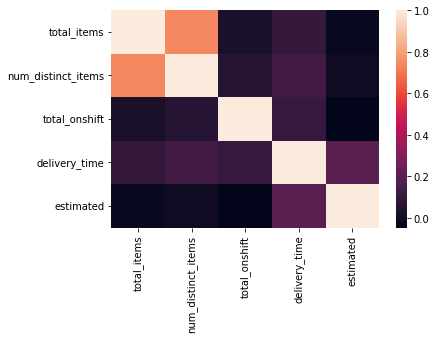

In [137]:
corr = df_train.corr()
sns.heatmap(corr)

In [138]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

scaler.fit(df[['total_onshift']])
df_train['total_onshift'] = scaler.transform(df_train[['total_onshift']])
df_test['total_onshift'] = scaler.transform(df_test[['total_onshift']])

scaler.fit(df[['estimated']])
df_train['estimated'] = scaler.transform(df_train[['estimated']])
df_test['estimated'] = scaler.transform(df_test[['estimated']])

scaler.fit(df[['total_items']])
df_train['total_items'] = scaler.transform(df_train[['total_items']])
df_test['total_items'] = scaler.transform(df_test[['total_items']])

scaler.fit(df[['num_distinct_items']])
df_train['num_distinct_items'] = scaler.transform(df_train[['num_distinct_items']])
df_test['num_distinct_items'] = scaler.transform(df_test[['num_distinct_items']])

scaler.fit(df[['delivery_time']])
df_train['delivery_time'] = scaler.transform(df_train[['delivery_time']])
df_test['delivery_time'] = scaler.transform(df_test[['delivery_time']])

In [139]:
df_train

,store_primary_category,total_items,num_distinct_items,total_onshift,delivery_time,meal_time,estimated
17333,american,-0.822007,-1.024370,-1.153637,-0.011671,21,-1.336196
155359,american,-0.447328,-0.410457,2.222388,0.064935,1,0.621270
97514,burger,-0.447328,-0.410457,-0.972779,-0.001840,23,0.272330
39763,american,0.676710,0.203456,-0.430203,-0.012593,22,-0.731935
34102,american,0.302031,-1.024370,-1.123494,0.015622,17,2.480863
...,...,...,...,...,...,...,...
126859,japanese,-0.447328,-0.410457,0.865949,0.014752,2,-0.378740
185353,mediterranean,-0.072649,0.203456,-0.912492,-0.028519,21,-1.948968
158625,mexican,0.676710,0.203456,-0.369917,-0.052382,19,0.425523
107041,asian,-0.447328,-0.410457,2.162102,0.029602,1,-1.523432


In [140]:
df_test

,store_primary_category,total_items,num_distinct_items,total_onshift,delivery_time,meal_time,estimated
70016,breakfast,-0.072649,-0.410457,-0.852206,-0.046646,1,0.408502
33198,italian,-0.447328,-0.410457,0.443946,-0.025293,2,-2.102161
92730,middle-eastern,-0.447328,-0.410457,0.926235,0.051417,4,1.553194
117598,italian,-0.447328,-0.410457,-0.068486,0.010911,2,0.502120
72391,american,-0.822007,-1.024370,-0.339774,-0.050948,19,-2.174503
...,...,...,...,...,...,...,...
187333,fast,5.172863,3.886937,0.835806,-0.069485,19,-1.021300
186248,mexican,-0.072649,-0.410457,1.167380,-0.046493,4,0.489354
18586,mediterranean,-0.447328,-0.410457,0.715234,-0.010852,4,-0.204270
134738,sandwich,-0.447328,-0.410457,-0.671348,0.039639,22,0.357437


In [141]:
df_test.head()

,store_primary_category,total_items,num_distinct_items,total_onshift,delivery_time,meal_time,estimated
70016,breakfast,-0.072649,-0.410457,-0.852206,-0.046646,1,0.408502
33198,italian,-0.447328,-0.410457,0.443946,-0.025293,2,-2.102161
92730,middle-eastern,-0.447328,-0.410457,0.926235,0.051417,4,1.553194
117598,italian,-0.447328,-0.410457,-0.068486,0.010911,2,0.502120
72391,american,-0.822007,-1.024370,-0.339774,-0.050948,19,-2.174503


## 학습

In [142]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [143]:
def custom_loss_train(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual>0, -2*5*residual, -2*residual)
    hess = np.where(residual>0, 2*5, 2.0)
    return grad, hess

def custom_loss_valid(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual > 0, (residual**2)*5, residual**2) 
    return "custom_loss_eval", np.mean(loss), False

In [144]:
def data_label_split(d):
    y = d['delivery_time']
    X = d.drop(['delivery_time'], axis=1)
    return X, y

X_train, y_train = data_label_split(df_train)
X_test, y_test = data_label_split(df_test)

In [145]:
X_train,  X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [146]:
model = lgb.LGBMRegressor()
model.set_params(**{'objective': custom_loss_train}, 
            metrics = ["rmse", 'mse'] )
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric = custom_loss_valid,
    verbose=False,
)

C:\Users\leejoon-byeong\anaconda3\envs\stdata\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\leejoon-byeong\anaconda3\envs\stdata\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\leejoon-byeong\anaconda3\envs\stdata\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMRegressor(metrics=['rmse', 'mse'],
              objective=<function custom_loss_train at 0x000001A03E923EE8>)

In [147]:
y_pred = model.predict(X_test)

In [148]:
y_test = scaler.inverse_transform([y_test])[0]
y_pred = scaler.inverse_transform([y_pred])[0]

In [149]:
print(y_pred)
print(y_test)

[3144.09503277 3036.01761385 3130.49824772 ... 2993.14881272 2983.27639475
 3234.15190194]
[1998. 2415. 3913. ... 2697. 3683. 2829.]


In [150]:
from sklearn.metrics import mean_squared_error

def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred) ** 0.5
    
def under_pred(y, y_pred):
    return sum(y_pred < y) / len(y)

In [151]:
print("rmse:", RMSE(y_test, y_pred))
print("under prediction:", under_pred(y_test, y_pred))

rmse: 1117.9303252064894
under prediction: 0.3040593490413249


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

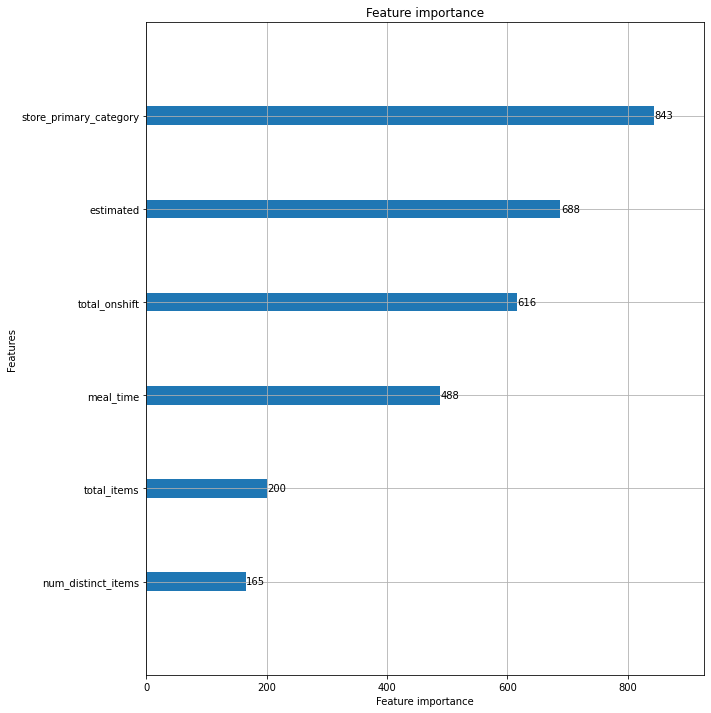

In [152]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(model, ax=ax)